In [1]:
import sys
sys.path.insert(0, '/home/tschernn/.local/opencv-cuda/lib/python3.10/dist-packages')

In [2]:
from keras.preprocessing.image import load_img
from skimage.feature import hog
from skimage import data, exposure
from scipy.spatial import distance
from tqdm import tqdm

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

2025-05-19 09:06:20.548667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-19 09:06:20.548789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-19 09:06:20.572801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 09:06:20.634455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 09:06:21.403926: W tensorflow/compiler/tf2

In [3]:
# make sure manually-compiled version of cv2 is used
import cv2
print(cv2.__file__)

/home/tschernn/.local/opencv-cuda/lib/python3.10/dist-packages/cv2/__init__.py


In [4]:
# check if cuda is available
if cv2.cuda.getCudaEnabledDeviceCount() == 1:
    print("CUDA detected!")

CUDA detected!


In [5]:
# load list of charter img paths

folders = [
    '../images/preprocessed_imgs/binary/writable_area/fr_notary',
    '../images/preprocessed_imgs/binary/writable_area/fr_papal',
    '../images/preprocessed_imgs/binary/writable_area/fr_other',
    '../images/preprocessed_imgs/binary/writable_area/at_notary',
    '../images/preprocessed_imgs/binary/writable_area/at_papal',
    '../images/preprocessed_imgs/binary/writable_area/at_other'
]
if isinstance(folders, str):
    folders = [folders]
charter_list = []
for folder in folders:
    files = os.listdir(folder)
    full_paths = [os.path.abspath(os.path.join(folder, f)) for f in files]
    charter_list.extend(full_paths)

charter_list

['/home/tschernn/images/preprocessed_imgs/binary/writable_area/fr_notary/wa_62f113115f5d2e4ead5b5c9e256bbe1e2.jpg',
 '/home/tschernn/images/preprocessed_imgs/binary/writable_area/fr_notary/wa_c7e12db9d6a8c09138e67b77818b1128.jpg',
 '/home/tschernn/images/preprocessed_imgs/binary/writable_area/fr_notary/wa_1a3f5a81f9bb7fabfe3012b2eccf4b17.jpg',
 '/home/tschernn/images/preprocessed_imgs/binary/writable_area/fr_notary/wa_667364aabe89e6dc65e939b80b212fa3.jpg',
 '/home/tschernn/images/preprocessed_imgs/binary/writable_area/fr_notary/wa_899fd4f8624fbaf5c0e426def2c0f493.jpg',
 '/home/tschernn/images/preprocessed_imgs/binary/writable_area/fr_notary/wa_abecb7d73e17bb5f70cb7c9052cad533.jpg',
 '/home/tschernn/images/preprocessed_imgs/binary/writable_area/fr_notary/wa_da478d335f3d171dab933ef1b82550f8.jpg',
 '/home/tschernn/images/preprocessed_imgs/binary/writable_area/fr_notary/wa_62f113115f5d2e4ead5b5c9e256bbe1e.jpg',
 '/home/tschernn/images/preprocessed_imgs/binary/writable_area/fr_notary/wa_102

In [6]:
charter_path = 'pickles/charter_list.pkl'

### export data as pickle file

with open(charter_path,'wb') as file:
    pickle.dump(charter_list, file)
    print(f'Saved features as {file.name}.')

Saved features as pickles/charter_list.pkl.


In [7]:
## set up HOG parameters

target_size = (1024, 1024)  # or (2048, 2048) or anything meaningful
cell_size = (16,16)
block_size = (32,32)
block_stride = (16,16)
nbins = 9

In [8]:
def visualize_hog_quiver(image_gray, cell_size=(8, 8), block_size=(16, 16), block_stride=(8, 8), nbins=9, scale=5):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    h, w = image_gray.shape
    h = h // cell_size[1] * cell_size[1]
    w = w // cell_size[0] * cell_size[0]
    image_gray = image_gray[:h, :w]

    hog = cv2.HOGDescriptor(
        (w, h),
        block_size,
        block_stride,
        cell_size,
        nbins
    )

    hog_feats = hog.compute(image_gray).reshape(-1, nbins)

    # compute grid size
    n_cells_x = w // cell_size[0]
    n_cells_y = h // cell_size[1]
    blocks_x = (n_cells_x - block_size[0] // cell_size[0]) + 1
    blocks_y = (n_cells_y - block_size[1] // cell_size[1]) + 1

    # Accumulate histograms
    hog_image = np.zeros((n_cells_y, n_cells_x, nbins), dtype=np.float32)
    block_norm = np.zeros((n_cells_y, n_cells_x), dtype=np.int32)

    idx = 0
    for y in range(blocks_y):
        for x in range(blocks_x):
            for dy in range(block_size[1] // cell_size[1]):
                for dx in range(block_size[0] // cell_size[0]):
                    cy = y + dy
                    cx = x + dx
                    if cy < n_cells_y and cx < n_cells_x:
                        hog_image[cy, cx] += hog_feats[idx]
                        block_norm[cy, cx] += 1
            idx += 1

    hog_image /= np.maximum(block_norm[..., np.newaxis], 1)

    # Vectorize: get dominant orientation per cell
    angle_unit = 180 / nbins
    angles = np.arange(nbins) * angle_unit + angle_unit / 2
    angles = np.deg2rad(angles)

    X, Y = np.meshgrid(np.arange(n_cells_x), np.arange(n_cells_y))

    # Compute dominant direction per cell
    magnitudes = np.linalg.norm(hog_image, axis=2)
    best_bins = np.argmax(hog_image, axis=2)
    theta = angles[best_bins]

    U = scale * magnitudes * np.cos(theta)
    V = scale * magnitudes * np.sin(theta)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image_gray, cmap='gray')
    plt.quiver(X * cell_size[0] + cell_size[0] // 2,
               Y * cell_size[1] + cell_size[1] // 2,
               U, V, color='red', angles='xy', scale_units='xy', scale=1)
    plt.title("HOG Quiver Visualization")
    plt.axis('off')
    #plt.show()
    plt.savefig("hog_vis.png", dpi=300)

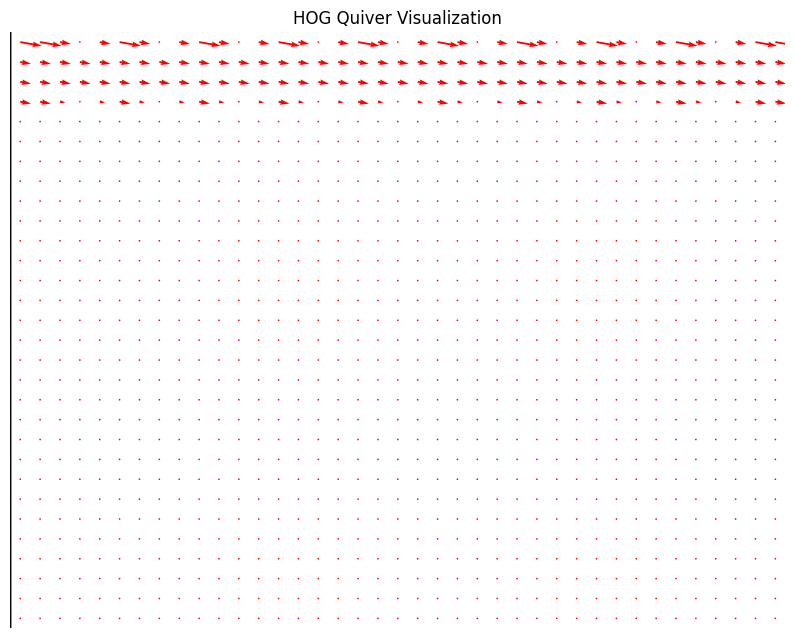

In [9]:
image = cv2.imread("white.jpg", cv2.IMREAD_GRAYSCALE)
visualize_hog_quiver(image, cell_size=(32,32), block_size=(64,64), block_stride=(32,32), nbins=9, scale=50)


In [10]:
## extract features

all_features = []
image_names = []

for charter in charter_list:
    image = cv2.imread(charter)

    if image is None:
        print(f"Could not load {charter}")
        continue
    
    # grayscale & resize
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.equalizeHist(image_gray) # histogram equalization to deal with uneven illumination - optional
    image_resized = cv2.resize(image_gray, target_size)
    
    # initialize HOG descriptor for target_size
    hog = cv2.HOGDescriptor(target_size, block_size, block_stride, cell_size, nbins)
    
    # compute feature vector
    features = hog.compute(image_resized).flatten()

    all_features.append(features)
    image_names.append(charter)

In [11]:
## save results

# convert to NumPy array (will only work if all feature vectors have the same size!)
all_features = np.vstack(all_features)

with open(f'pickles/features_hog.pkl', 'wb') as handle:
    pickle.dump(all_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved {len(all_features)} feature vectors.")

Saved 312 feature vectors.


In [12]:
np.shape(all_features)

(312, 142884)

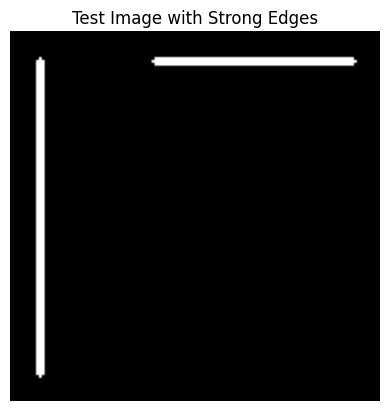

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a simple test image with strong edges
test_img = np.zeros((128, 128), dtype=np.uint8)
cv2.line(test_img, (10, 10), (10, 118), 255, 2)  # vertical line
cv2.line(test_img, (50, 10), (118, 10), 255, 2)  # horizontal line

plt.imshow(test_img, cmap='gray')
plt.title("Test Image with Strong Edges")
plt.axis('off')
#plt.show()

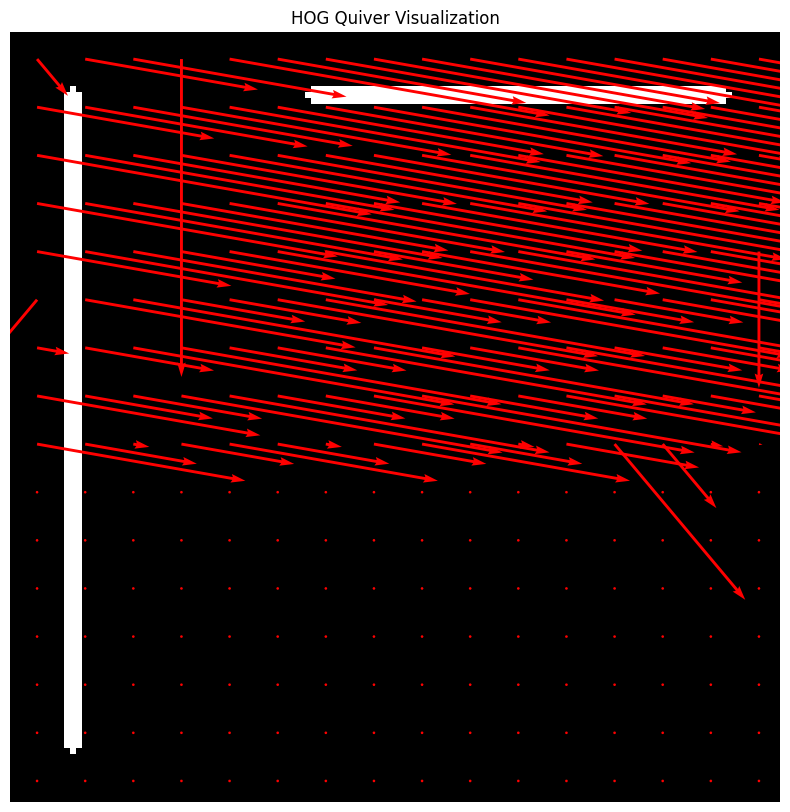

In [14]:
visualize_hog_quiver(
    test_img,
    cell_size=(8, 8),
    block_size=(16, 16),
    block_stride=(8, 8),
    nbins=9,
    scale=100
)